# Stock Price Prediction App 📈
##This machine learning model tries to predict future prices for SPY ETF index fund based on past data.

**We will be using the LSTM model to predict future price.**

[Learn more about LSTM in this video!](https://www.youtube.com/watch?v=5dMXyiWddYs&ab_channel=DigitalSreeni)


In [ ]:
# First we will import the necessary Library

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import math
import os
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# For PLotting we will use these library

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
# Pull Historical Data from SPY

spy_ticker = yf.Ticker("SPY")
spy = spy_ticker.history(period="max")
spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29 00:00:00-05:00,25.352037,25.352037,25.225908,25.334019,1003200,0.0,0
1993-02-01 00:00:00-05:00,25.352030,25.514196,25.352030,25.514196,480500,0.0,0
1993-02-02 00:00:00-05:00,25.496199,25.586292,25.442144,25.568274,201300,0.0,0
1993-02-03 00:00:00-05:00,25.604289,25.856548,25.586271,25.838530,529400,0.0,0
1993-02-04 00:00:00-05:00,25.928637,26.000711,25.640341,25.946655,531500,0.0,0
...,...,...,...,...,...,...,...
2022-10-17 00:00:00-04:00,364.010010,367.980011,357.279999,366.820007,93168200,0.0,0
2022-10-18 00:00:00-04:00,375.130005,375.450012,367.519989,371.130005,97162900,0.0,0
2022-10-19 00:00:00-04:00,368.989990,371.850006,365.549988,368.500000,79746900,0.0,0


In [ ]:
spy.index = pd.to_datetime(spy.index)
spy.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
spy.reset_index(inplace=True)

In [ ]:
closed_stock = spy[['Date','Close']]
df = spy[['Date','Close']]

#Filiter dataframe from 2008 onwards
closed_stock = spy[spy['Date']>'2016-01-01']
df = df[df['Date']>'2016-01-01']
print("Shape of dataframe:", closed_stock.shape)

Shape of dataframe: (1714, 6)


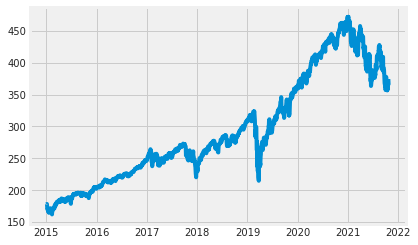

In [ ]:
# Graph of SPY Performance
plt.plot(closed_stock.Date, closed_stock['Close'])

In [ ]:
#Apply Normalization on Closed Price
df.drop(['Date'], axis=1, inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
closed=scaler.fit_transform(np.array(df).reshape(-1,1))
print(closed.shape)

(1714, 1)


In [ ]:
training_size=int(len(closed)*0.60)
test_size=len(closed)-training_size
train_data,test_data=closed[0:training_size,:], closed[training_size:len(closed),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1028, 1)
test_data:  (686, 1)


In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
#incrementally adding the previous lists of each time stamp for each row

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1012, 15)
y_train:  (1012,)
X_test:  (670, 15)
y_test (670,)


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1012, 15, 1)
X_test:  (670, 15, 1)


In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

### Model is now being trained on past data. We will be using the LSTM (long short term memory) neural network to fit our data.###
**This will take a couple of minutes.🤓**

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
32/32 [==============================] - 4s 37ms/step - loss: 0.0300 - val_loss: 0.0533
Epoch 2/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 3/200
32/32 [==============================] - 1s 20ms/step - loss: 9.5815e-04 - val_loss: 0.0083
Epoch 4/200
32/32 [==============================] - 1s 18ms/step - loss: 2.0494e-04 - val_loss: 0.0237
Epoch 5/200
32/32 [==============================] - 1s 20ms/step - loss: 1.4537e-04 - val_loss: 0.0159
Epoch 6/200
32/32 [==============================] - 1s 16ms/step - loss: 1.3150e-04 - val_loss: 0.0148
Epoch 7/200
32/32 [==============================] - 1s 17ms/step - loss: 1.3009e-04 - val_loss: 0.0142
Epoch 8/200
32/32 [==============================] - 1s 19ms/step - loss: 1.2969e-04 - val_loss: 0.0151
Epoch 9/200
32/32 [==============================] - 1s 18ms/step - loss: 1.2829e-04 - val_loss: 0.0135
Epoch 10/200
32/32 [==============================] - 1s 19ms/step - los

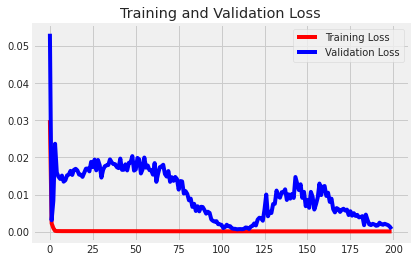

<Figure size 432x288 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In this chart, you should see that training and validation loss decrease overtime. This means that we were able to fit a model to the data.

**This model will now attempt to predict SPY prices for training and validation data...**

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

21/21 [==============================] - 0s 2ms/step


((1012, 1), (670, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.3531921138351013
Train data MSE:  5.537513124615712
Train data MAE:  1.6543955143261333
-------------------------------------------------------------------------------------
Test data RMSE:  7.997148199699111
Test data MSE:  63.95437932795073
Test data MAE:  6.253660173558477


In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9963401966649658
Test data explained variance regression score: 0.9865801283924378


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9957652864083278
Test data R2 score: 0.9811657678853014


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closed)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closed)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closed)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original Close Price','Train Predicted Close Price','Test Predicted Close Price'])


plotdf = pd.DataFrame({'date': closed_stock['Date'],
                       'original_close': closed_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock Price','date': 'Date'})
fig.update_layout(plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1714, 1)
Test predicted data:  (1714, 1)


In this chart, we compare between original close price to predicted close price for training and testing data. We can also see the R2 Score (measures how well our model will be able to predict future values) compares below.

In [ ]:
# Predicting next 5 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

1 day input [0.69616637 0.69333017 0.68079299 0.64724222 0.63831462 0.63096633
 0.62716329 0.65749113 0.63061185 0.66023065 0.67412149 0.66564516
 0.65568629 0.68430598 0.67061931]
1 day output [[0.6700797]]
[0.6961663651966954, 0.6933301656077555, 0.6807929949529004, 0.6472422173561034, 0.6383146211468895, 0.6309663305556392, 0.6271632894505641, 0.6574911308519669, 0.6306118547851254, 0.6602306462892933, 0.6741214934229449, 0.6656451554920655, 0.6556862944510429, 0.6843059836031351, 0.6706193089485168, 0.6700797080993652]
2 day input [0.69333017 0.68079299 0.64724222 0.63831462 0.63096633 0.62716329
 0.65749113 0.63061185 0.66023065 0.67412149 0.66564516 0.65568629
 0.68430598 0.67061931 0.67007971]
2 day output [[0.66923916]]
[0.6933301656077555, 0.6807929949529004, 0.6472422173561034, 0.6383146211468895, 0.6309663305556392, 0.6271632894505641, 0.6574911308519669, 0.6306118547851254, 0.6602306462892933, 0.6741214934229449, 0.6656451554920655, 0.6556862944510429, 0.6843059836031351, 0

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20]


In [ ]:
temp_mat = np.empty((len(last_days)+len(day_pred)+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closed[len(closed)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new = new_pred_plot.iloc[:16]
new2 = new_pred_plot.iloc[15:]


fig = go.Figure()
fig.add_trace(go.Scatter(x=new_pred_plot.index, y=new['last_original_days_value'],
                    mode='lines',
                    name='Last 15 Days Close Price',
                    line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=new2.index, y=new2['next_predicted_days_value'],
                    mode='lines+markers',
                    name='Next Predicted 5 Days Close Price',
                    line=dict(color='firebrick', width=4)))

#names = cycle(['Last 15 days close price','Predicted next 5 days close price'])

#fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      #new_pred_plot['next_predicted_days_value']],
              #labels={'value': 'Stock price','index': 'Timestamp'},  markers=True)


fig.update_layout(title_text='Compare the past stock prices for the last 15 days vs predict the next 5 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

#fig.for_each_trace(lambda t:  t.update(name = next(names)))


fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

This chart shows the past 15 days of closed price data and what the model predicts for the next 5 days. More volatile prices can mean less accurate predictions. The SPY ETF is a good example to use to predict prices because it is less volatile than individual stocks.

In [ ]:
lstmdf=closed.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

lstmdf_1 = pd.DataFrame({
    'close price':lstmdf
})

lstmdf_2 = lstmdf_1.iloc[len(lstmdf_1)-5:]

names = cycle(['Close Price'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=lstmdf_1.index, y=lstmdf_1['close price'],
                    mode='lines',
                    name='Past Close Price',
                    line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=lstmdf_2.index, y=lstmdf_2['close price'],
                    mode='lines',
                    name='Predicted Close Price',
                    line=dict(color='firebrick', width=4)))

fig.update_layout(title_text='Closing Stock Price With Predicted Close Price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.show()

In conclusion, LSTM is an great model to use when predicting market prices. This is because LSTM takes past closed price predictions as an input for the neural network. But like any machine learning algorithm, some trends will not be captured closely due to the unpredictablity of price movement.

When looking at longer time frames such as the next year's prices, the predictions get less accurate. This is because this model will rely heavily on predicted data only and not actual close prices. Since the model only uses the past 15 days worth of data to predict the next close price.

The model also has a harder time predicting prices when prices are volatile. Market prices can be volatile due to many variables like inflation, supply and demand, war, company financial results and unexpected news.

This model might be worth using to look at shorter time frames and it does a good job of showing general trends of where prices are heading.

This was a fun project to try and learn more about how the SPY ETF prices move and seeing how machine learning can potentially be implemented to predict future prices. 😁

**Disclaimer: Please do not invest money based on these results as the stock market for the most part is still unpredictable.**